In [1]:
# --- INSTALLING LIBRARIES ---
!pip install --upgrade transformers accelerate datasets scikit-learn -q

# --- IMPORTING LIBRARIES ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
# 💥 CHANGE 1: Import RobertaModel (The new text model)
from transformers import AutoTokenizer, RobertaModel, TrainingArguments, Trainer 
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight 
import matplotlib.pyplot as plt
import seaborn as sns
import os

RNG = 42

# --- LOADING THE DATASET ---

FILE_PATH = '/kaggle/input/non-english-removed-194k-data/Non English reviews deleted All_Language_Data - Copy.csv' 

print(f"Loading dataset from: {FILE_PATH}")

try:
    # 💥 FIX: Use raw_df for initial load
    raw_df = pd.read_csv(FILE_PATH) 
except FileNotFoundError:
    print("\n❌ ERROR: File not found!")
    print(f"Please verify the path: {FILE_PATH}")
    print("Tip: In Kaggle, check the 'Input' section on the right sidebar to copy the exact path.")
    raise

# --- SANITY CHECK ---
needed_cols = [
    'title', 'reviewText', 'audienceScore', 'tomatoMeter', 'runtimeMinutes',
    'genre', 'language_encoded', 'director_encoded', 'sentiment_label'
]

missing = [c for c in needed_cols if c not in raw_df.columns]
if missing:
    raise ValueError(f"❌ CRITICAL ERROR: Your CSV is missing these columns: {missing}")

print("--- Part 1: Setup and Data Loading Complete (Kaggle Version) ---")
print(f"Dataset loaded with {raw_df.shape[0]} rows.")
print(f"Target Label Source (to be binarized/filtered):\n{raw_df['sentiment_label'].value_counts().sort_index()}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.

2025-11-22 17:25:19.140348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763832319.530414      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763832319.640839      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Loading dataset from: /kaggle/input/non-english-removed-194k-data/Non English reviews deleted All_Language_Data - Copy.csv
--- Part 1: Setup and Data Loading Complete (Kaggle Version) ---
Dataset loaded with 194801 rows.
Target Label Source (to be binarized/filtered):
sentiment_label
0    97036
1    97765
Name: count, dtype: int64


In [2]:
# --- PART 2: PREPROCESSING & FEATURE ENGINEERING (BINARY - FINAL FIX) ---

import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from packaging import version
import sklearn

# Ensure 'raw_df' and 'RNG' exist from Part 1
if 'raw_df' not in globals():
    raise ValueError("❌ 'raw_df' is missing! Please run Part 1 to load the data first.")

# FIX: Copy raw_df to df for local operations
df = raw_df.copy()

# --- CLEANING & BINARIZATION (FIXED) ---
print("Cleaning data (already binary, no filtering needed)...")
# 1. Use the existing sentiment_label column directly
df = df.dropna(subset=['reviewText', 'sentiment_label']).copy() 
df['label'] = df['sentiment_label'].astype(int) # Maps existing 0/1 to the final label column

class_names = ['Negative', 'Positive'] 
N_CLASSES = 2 
                 
# Text Prep
df['title'] = df['title'].fillna("")
df['genre'] = df['genre'].fillna("Unknown")
df['combined_text'] = df['title'] + " [SEP] " + df['reviewText']

# --- STRATIFIED SPLIT (Correct) ---
print("Splitting data (Stratified)...")
train_idx, test_idx = train_test_split(
    df.index, test_size=0.2, random_state=RNG, stratify=df['label']
)
train_df = df.loc[train_idx].reset_index(drop=True)
test_df  = df.loc[test_idx].reset_index(drop=True)

y_train = train_df['label'].values.astype(int)

# ==========================================
# CRITICAL: CALCULATE CLASS WEIGHTS
# ==========================================
print("Calculating class weights...")

classes_in_y = np.unique(y_train)

class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=classes_in_y, # Use only classes found in the data
    y=y_train
)

class_weights = torch.tensor(class_weights_np, dtype=torch.float)

# 2. Add a safety step to ensure the tensor is size [2] for the model's loss function
if len(class_weights) == 1 and N_CLASSES == 2:
    print("\n[WARNING] Only one class found in y_train. Forcing weights to [1.0, 1.0] to prevent downstream CrossEntropyLoss crash.")
    class_weights = torch.tensor([1.0, 1.0], dtype=torch.float)

print("\n⚖️ Calculated Class Weights (Neg, Pos):")
print(class_weights)

# ==========================================
# FEATURE ENGINEERING (Fit on Train)
# ==========================================
print("Starting Feature Engineering...")
NUMERIC_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']
train_numeric = train_df[NUMERIC_COLS].copy(); train_medians = train_numeric.median(numeric_only=True); train_numeric = train_numeric.fillna(train_medians)
scaler = StandardScaler(); scaler.fit(train_numeric.values)

train_genre_list = train_df['genre'].fillna("Unknown").str.split(', '); mlb = MultiLabelBinarizer(); mlb.fit(train_genre_list)

train_lang = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
else:
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.float32)
ohe_lang.fit(train_lang.to_frame())

# 4. Categorical: Director (Robust Target Encoding - BINARY VERSION)
print("-> Processing Director (Target Encoding - BINARY)...")
def director_features_binary(train_s, y, test_s, n_splits=5):
    """Adaptation of target encoding for binary task (only need one target mean feature)."""
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    # Frequency
    freq = s_train.value_counts()
    tr_freq = np.log1p(s_train.map(freq).fillna(0).values)[:, None].astype(np.float32)
    te_freq = np.log1p(s_test.map(freq).fillna(0).values)[:, None].astype(np.float32)

    # K-Fold Target Mean (Target is 0 or 1, so mean is just the positive rate)
    global_mean = y.mean()

    tr_te = np.zeros(len(s_train), dtype=np.float32)[:, None] # Shape (N, 1)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)

    for tr_i, val_i in skf.split(np.zeros(len(y)), y):
        tr_fold_s = s_train.iloc[tr_i]
        tr_fold_y = y[tr_i]
        
        fold_means = pd.Series(tr_fold_y, index=tr_fold_s.index).groupby(tr_fold_s).mean()
        val_te = s_train.iloc[val_i].map(fold_means)
        
        tr_te[val_i, 0] = val_te.fillna(global_mean).values.astype(np.float32)

    # Test set mapping (using full train mean)
    full_means = pd.Series(y, index=s_train.index).groupby(s_train).mean()
    te_te = s_test.map(full_means).fillna(global_mean).values[:, None].astype(np.float32)

    return tr_freq, te_freq, tr_te, te_te

# Apply Director Encoding
dtr_f, dte_f, dtr_te, dte_te = director_features_binary(
    train_df['director_encoded'].astype(str), y_train,
    test_df['director_encoded'].astype(str)
)

dir_train_block = np.concatenate([dtr_f, dtr_te], axis=1).astype(np.float32)
dir_test_block  = np.concatenate([dte_f, dte_te], axis=1).astype(np.float32)

print("--- Part 2: Preprocessing & Weights Complete ---")

Cleaning data (already binary, no filtering needed)...
Splitting data (Stratified)...
Calculating class weights...

⚖️ Calculated Class Weights (Neg, Pos):
tensor([1.0038, 0.9963])
Starting Feature Engineering...
-> Processing Director (Target Encoding - BINARY)...
--- Part 2: Preprocessing & Weights Complete ---


In [3]:
# --- PART 3: DATASET CREATION & TOKENIZATION (FINAL) ---

import numpy as np
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

NUMERIC_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes'] 

# Ensure prerequisites from Part 2 exist
required_vars = ['train_df', 'test_df', 'dir_train_block', 'dir_test_block', 'scaler', 'mlb', 'ohe_lang', 'train_medians']
if not all(v in globals() for v in required_vars):
    raise ValueError("❌ Missing variables from Part 2. Please run the previous cell first.")

# Define helper function (unchanged)
def build_features(split_df, dir_block):
    out = {}
    out['combined_text'] = split_df['combined_text'].tolist()
    out['label'] = split_df['label'].astype(int).tolist()

    # Numeric (3 features)
    numeric = split_df[NUMERIC_COLS].copy().fillna(train_medians)
    out['numerical_features'] = scaler.transform(numeric.values).astype(np.float32)

    # Genre (multi-hot)
    genre_list = split_df['genre'].fillna("Unknown").str.split(', ')
    
    # Concatenate all categorical features (Genre + Language + Director Block (2 features))
    out['categorical_features'] = np.concatenate([
        mlb.transform(genre_list),
        ohe_lang.transform(split_df['language_encoded'].astype('Int64').astype(str).fillna('unknown').to_frame()),
        dir_block
    ], axis=1).astype(np.float32)
    
    return out

print("Building features dictionaries...")
train_feats = build_features(train_df, dir_train_block)
test_feats  = build_features(test_df, dir_test_block)

# Dimensions
num_numerical_features = 3
num_categorical_features = train_feats['categorical_features'].shape[1]
print(f"Feature Dims: Numeric={num_numerical_features}, Categorical={num_categorical_features}")

# HF Dataset
print("Converting to Hugging Face Datasets...")
raw_datasets = DatasetDict({
    'train': Dataset.from_dict(train_feats),
    'test':  Dataset.from_dict(test_feats),
})

# Tokenization
# 💥 CHANGE 2: Use RoBERTa-Base checkpoint
MODEL_CHECKPOINT = "roberta-base" # Using RoBERTa-Base 

print(f"Downloading Tokenizer ({MODEL_CHECKPOINT})...")
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT) 
except Exception as e:
    print("\n❌ ERROR: Could not download tokenizer. Check Internet connection.")
    raise e

def tokenize_fn(examples):
    # Truncate/pad to 256 tokens for memory efficiency
    return tokenizer(examples["combined_text"], padding="max_length", truncation=True, max_length=256)

print("Tokenizing dataset (this may take a moment)...")
tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["combined_text"])
tokenized_datasets.set_format("torch")

print("--- Part 3: Dataset Ready & Tokenized ---")

Building features dictionaries...
Feature Dims: Numeric=3, Categorical=48
Converting to Hugging Face Datasets...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizing dataset (this may take a moment)...


Map:   0%|          | 0/155840 [00:00<?, ? examples/s]

Map:   0%|          | 0/38961 [00:00<?, ? examples/s]

--- Part 3: Dataset Ready & Tokenized ---


In [4]:
# --- PART 4: MODEL SETUP & TRAINING (BINARY RoBERTa) ---

import torch
import torch.nn as nn
# 💥 CHANGE 3: Import RobertaModel
from transformers import Trainer, TrainingArguments, RobertaModel 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import os

# --- SAFETY CHECK ---
if 'class_weights' not in globals():
    raise ValueError("❌ 'class_weights' is missing! Please run Part 2 first.")
if 'MODEL_CHECKPOINT' not in globals():
    raise ValueError("❌ 'MODEL_CHECKPOINT' is missing! Please run Part 3 first.")

# --- MODEL ARCHITECTURE ---
class MultimodalClassifier(nn.Module):
    def __init__(self, num_labels, num_numerical, num_categorical):
        super().__init__()
        # Initialize RobertaModel
        # 💥 CHANGE 4: Use RobertaModel instead of DebertaV2Model
        self.roberta = RobertaModel.from_pretrained(MODEL_CHECKPOINT) 
        self.dropout = nn.Dropout(0.2)
        # Hidden size for roberta-base is 768
        self.classifier = nn.Linear(
            self.roberta.config.hidden_size + num_numerical + num_categorical,
            num_labels
        )
        self.num_labels = num_labels

    # 💥 CHANGE 5: Use self.roberta and its config
    def forward(self, input_ids, attention_mask, numerical_features, categorical_features, labels=None):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        # RoBERTa uses the first token's output for classification
        pooled_output = self.dropout(roberta_output.last_hidden_state[:, 0])

        combined = torch.cat([pooled_output, numerical_features, categorical_features], dim=1)
        logits = self.classifier(combined)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else (None, logits)

# --- CUSTOM TRAINER (Handles weighted loss) ---
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs[1]

        classifier_layer = model.module.classifier if hasattr(model, "module") else model.classifier

        # Move weights to the correct device
        weights = class_weights.to(classifier_layer.weight.device)

        # Weighted Loss Calculation
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits.view(-1, self.model.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# --- DATA COLLATOR, METRICS (Binary specific) ---
class MultimodalDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, features):
        batch = self.tokenizer.pad(
            [{"input_ids": f["input_ids"], "attention_mask": f["attention_mask"]} for f in features],
            return_tensors="pt"
        )
        batch['labels'] = torch.tensor([f['label'] for f in features], dtype=torch.long)
        batch['numerical_features'] = torch.stack([f['numerical_features'] for f in features])
        batch['categorical_features'] = torch.stack([f['categorical_features'] for f in features])
        return batch

def compute_metrics(pred):
    labels = pred.label_ids
    predictions = pred.predictions[0] if isinstance(pred.predictions, tuple) else pred.predictions
    preds = predictions.argmax(-1)
    
    # Use 'binary' average for the binary task
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0) 
    acc = accuracy_score(labels, preds)
    
    return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': rec}

# --- INIT MODEL ---
multimodal_model = MultimodalClassifier(
    num_labels=N_CLASSES, # N_CLASSES is 2
    num_numerical=num_numerical_features,
    num_categorical=num_categorical_features
)

# 💥 CHANGE 6: Update output directory name
OUTPUT_DIR = "/kaggle/working/Model_Results_Binary_Weighted_RoBERTa_Base" 

multimodal_training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=2e-5,
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=16,
    num_train_epochs=3, 
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy", 
    greater_is_better=True,
    save_total_limit=2,
    report_to="none",
    logging_steps=100,
    fp16=True 
)

multimodal_trainer = WeightedTrainer(
    model=multimodal_model,
    args=multimodal_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=MultimodalDataCollator(tokenizer),
    compute_metrics=compute_metrics,
)

print(f"--- Part 4: RoBERTa Base Weighted Training Setup Complete (3 Epochs) ---")
print(f"Saving checkpoints to: {OUTPUT_DIR}")
print(f"Training Batch Size: {multimodal_training_args.per_device_train_batch_size}")
multimodal_trainer.train()
print("--- Training Complete ---")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


--- Part 4: RoBERTa Base Weighted Training Setup Complete (3 Epochs) ---
Saving checkpoints to: /kaggle/working/Model_Results_Binary_Weighted_RoBERTa_Base
Training Batch Size: 16


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.268000,0.271039,0.894690,0.896574,0.883984,0.909528
2,0.190600,0.256680,0.903570,0.904990,0.895098,0.915103
3,0.145100,0.284990,0.903339,0.904387,0.897958,0.910909


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


--- Training Complete ---



--- Final Evaluation on Test Set ---


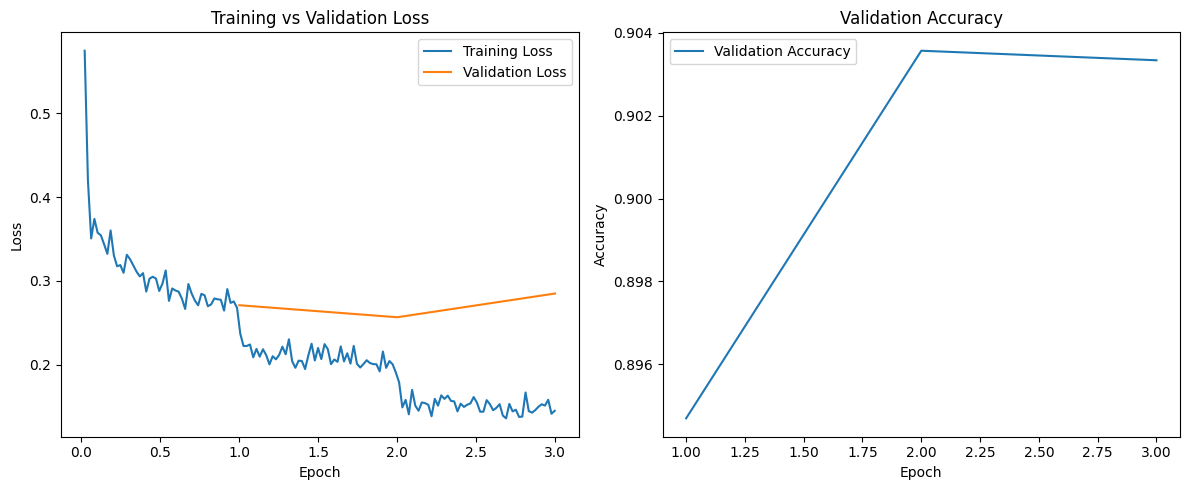

Generating predictions...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- Classification Report (BINARY RoBERTa) ---
              precision    recall  f1-score   support

    Negative     0.9125    0.8920    0.9021     19408
    Positive     0.8951    0.9151    0.9050     19553

    accuracy                         0.9036     38961
   macro avg     0.9038    0.9035    0.9035     38961
weighted avg     0.9038    0.9036    0.9036     38961



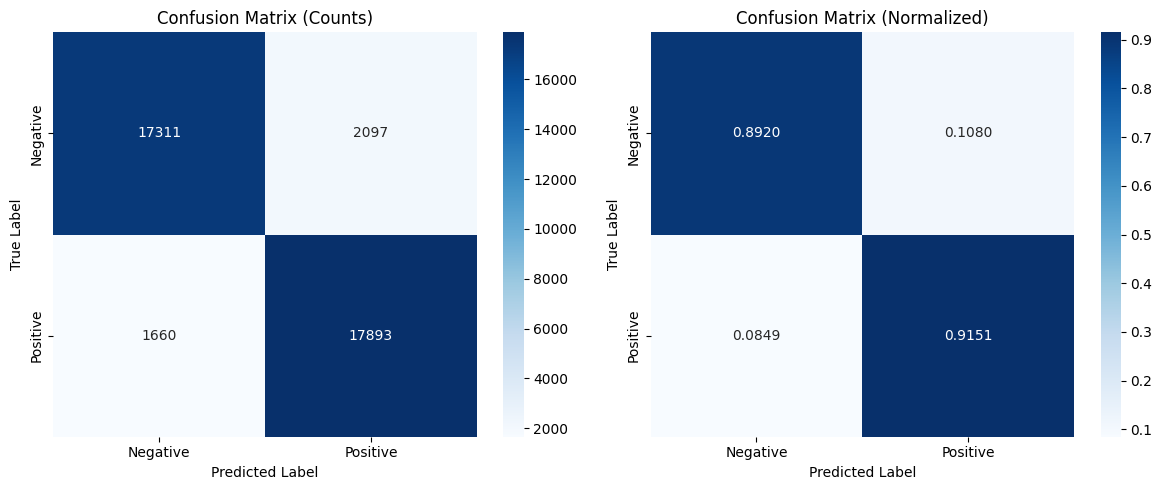

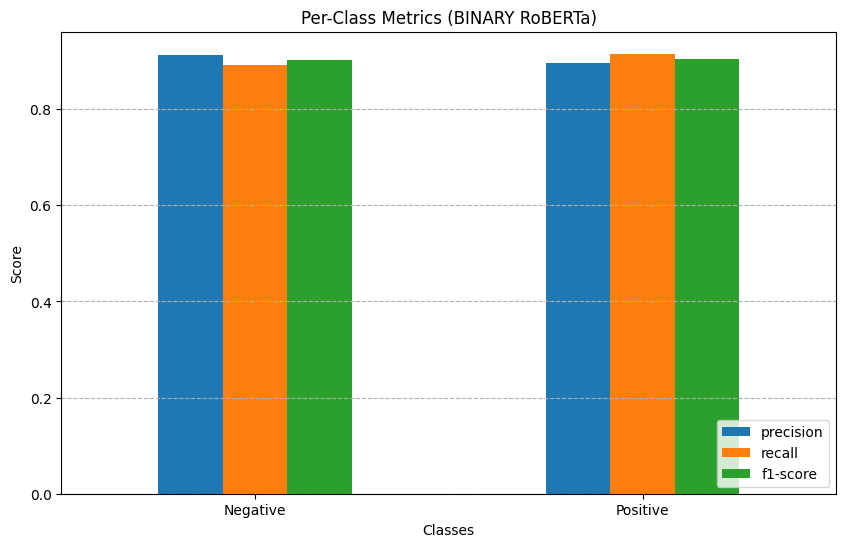


💾 Saving model to /kaggle/working/Final_Model_Binary_RoBERTa_Base_All_Features...
📦 Zipping model for easy download...
✅ DONE! You can now download 'Final_Model_Binary_RoBERTa_Base_All_Features.zip' from the 'Output' tab on the right.


In [5]:
# --- PART 5: EVALUATION & SAVING (KAGGLE VERSION - BINARY) ---

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import shutil # For zipping the model

# ==========================
# EVALUATE • REPORT • PLOTS • SAVE
# ==========================
print("\n--- Final Evaluation on Test Set ---")

trainer = multimodal_trainer # Use the trainer from Part 4
tokenized_datasets = tokenized_datasets # Use the dataset from Part 3

# 1. PLOT LOSS CURVES 
log_history = trainer.state.log_history
train_logs = [log for log in log_history if ('loss' in log and 'eval_loss' not in log)]
eval_logs = [log for log in log_history if ('eval_loss' in log)]

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot([log.get('epoch', i) for i, log in enumerate(train_logs, 1)], [log['loss'] for log in train_logs], label='Training Loss')
plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)], [log['eval_loss'] for log in eval_logs], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training vs Validation Loss'); plt.legend()


# Accuracy Plot
plt.subplot(1, 2, 2)
if len(eval_logs) > 0 and 'eval_accuracy' in eval_logs[0]:
    plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)], [log['eval_accuracy'] for log in eval_logs], label='Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Validation Accuracy'); plt.legend()
plt.tight_layout(); plt.show()


# 2. PREDICTIONS 
print("Generating predictions...")
preds_output = trainer.predict(tokenized_datasets["test"])

# --- SAFETY CHECK START ---
logits = preds_output.predictions[0] if isinstance(preds_output.predictions, tuple) else preds_output.predictions 
# --- SAFETY CHECK END ---

pred_labels = np.argmax(logits, axis=-1)
true_labels = np.array(tokenized_datasets["test"]["label"])

# 3. CLASSIFICATION REPORT 
print("\n--- Classification Report (BINARY RoBERTa) ---")
# Use the binary class_names defined in Part 2
report_dict = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True, zero_division=0)

# digits=4 for detailed precision
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4, zero_division=0))

# 4. CONFUSION MATRIX 
cm = confusion_matrix(true_labels, pred_labels)
row_sums = cm.sum(axis=1, keepdims=True); row_sums[row_sums == 0] = 1 # Safety for zero division
cm_norm = cm.astype('float') / row_sums

plt.figure(figsize=(12, 5))

# Counts (Integers)
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Counts)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Normalized (Floats with 4 decimals)
plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


plt.tight_layout()
plt.show()

# 5. PER-CLASS BAR CHART
report_df = pd.DataFrame(report_dict).transpose()
report_df_classes = report_df.loc[[cn for cn in class_names if cn in report_df.index]]
ax = report_df_classes[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Per-Class Metrics (BINARY RoBERTa)')
plt.xlabel('Classes'); plt.ylabel('Score')
plt.xticks(rotation=0); plt.grid(axis='y', linestyle='--'); plt.legend(loc='lower right')
plt.show()

# 6. SAVE (KAGGLE SPECIFIC)
# 💥 CHANGE 7: Update final model directory name
FINAL_MODEL_DIR = "Final_Model_Binary_RoBERTa_Base_All_Features" 
FINAL_MODEL_PATH = f"/kaggle/working/{FINAL_MODEL_DIR}"

print(f"\n💾 Saving model to {FINAL_MODEL_PATH}...")
trainer.save_model(FINAL_MODEL_PATH)

# --- ZIP FOR DOWNLOAD ---
print("📦 Zipping model for easy download...")
shutil.make_archive(f"/kaggle/working/{FINAL_MODEL_DIR}", 'zip', FINAL_MODEL_PATH)

print(f"✅ DONE! You can now download '{FINAL_MODEL_DIR}.zip' from the 'Output' tab on the right.")